# Background construction

This notebook examines the background construction method and errors.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import parameters as param
import mpi4py.MPI as MPI
import uuid
%matplotlib notebook

In [164]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

In [165]:
domain, p_full, a_full = atmos.solve_hydrostatic_pressure(param, np.float64)
p_full, p, a_full, a, heq, N2 = atmos.truncate_background(param, p_full, a_full)

2018-05-03 22:34:59,071 domain 0/1 DEBUG :: Global coeff shape: [256]
2018-05-03 22:34:59,072 distributor 0/1 DEBUG :: Mesh: []
2018-05-03 22:34:59,075 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-03 22:34:59,076 problems 0/1 DEBUG ::   Condition: True
2018-05-03 22:34:59,077 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-03 22:34:59,078 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-03 22:34:59,081 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-03 22:34:59,082 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-03 22:34:59,090 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-03 22:34:59,092 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-03 22:34:59,093 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-03 22:34:59,094 problems 0/1 DEBUG ::   Condition: True
2018-05-03 22:34:59,095 

## Examine truncation accuracy

<IPython.core.display.Javascript object>


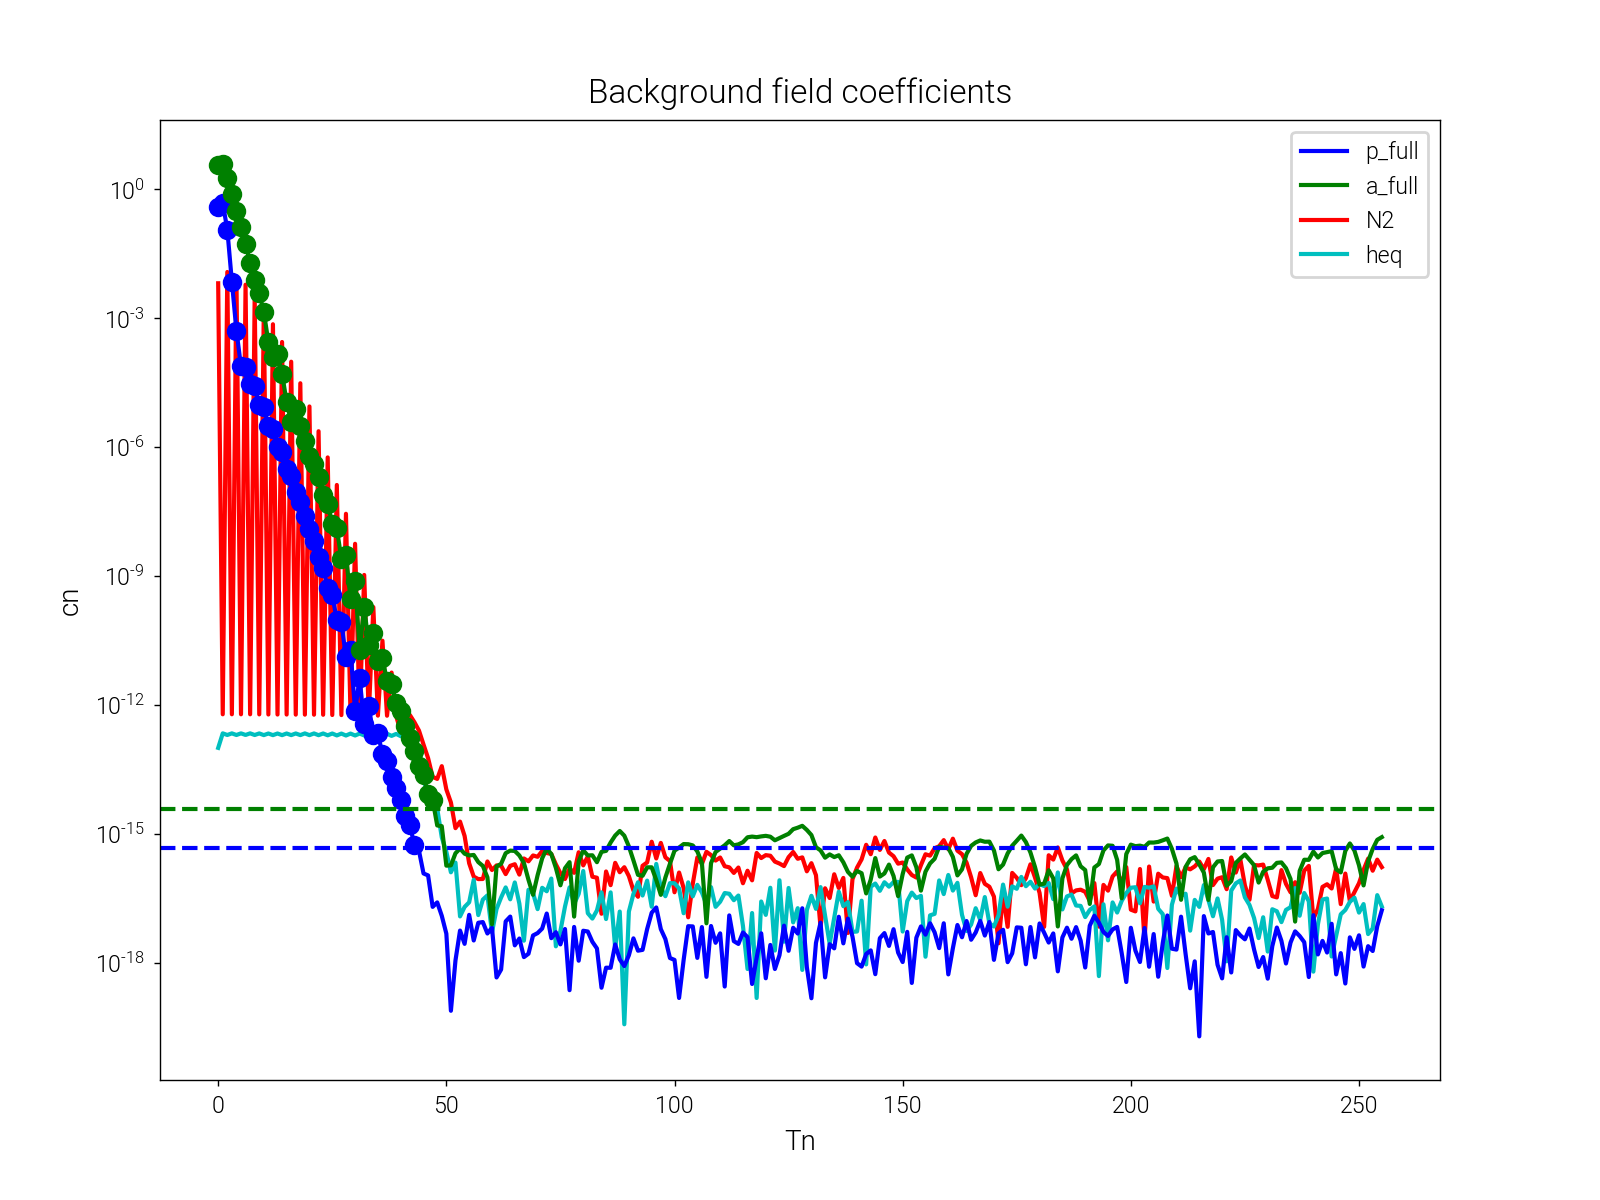

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [166]:
# Plot coefficients
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p_full['c']), '-', label='p_full')
axes.semilogy(np.abs(a_full['c']), '-', label='a_full')
axes.semilogy(np.abs(N2['c']), '-', label='N2', zorder=0)
axes.semilogy(np.abs(heq['c']), '-', label='heq', zorder=0)
axes.set_color_cycle(None)
axes.semilogy(np.abs(p['c']), 'o')
axes.semilogy(np.abs(a['c']), 'o')
axes.set_color_cycle(None)
axes.axhline(param.pressure_floor*np.max(np.abs(p_full['c'])), ls='dashed', c='b')
axes.axhline(param.background_floor*np.max(np.abs(a_full['c'])), ls='dashed', c='g')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>


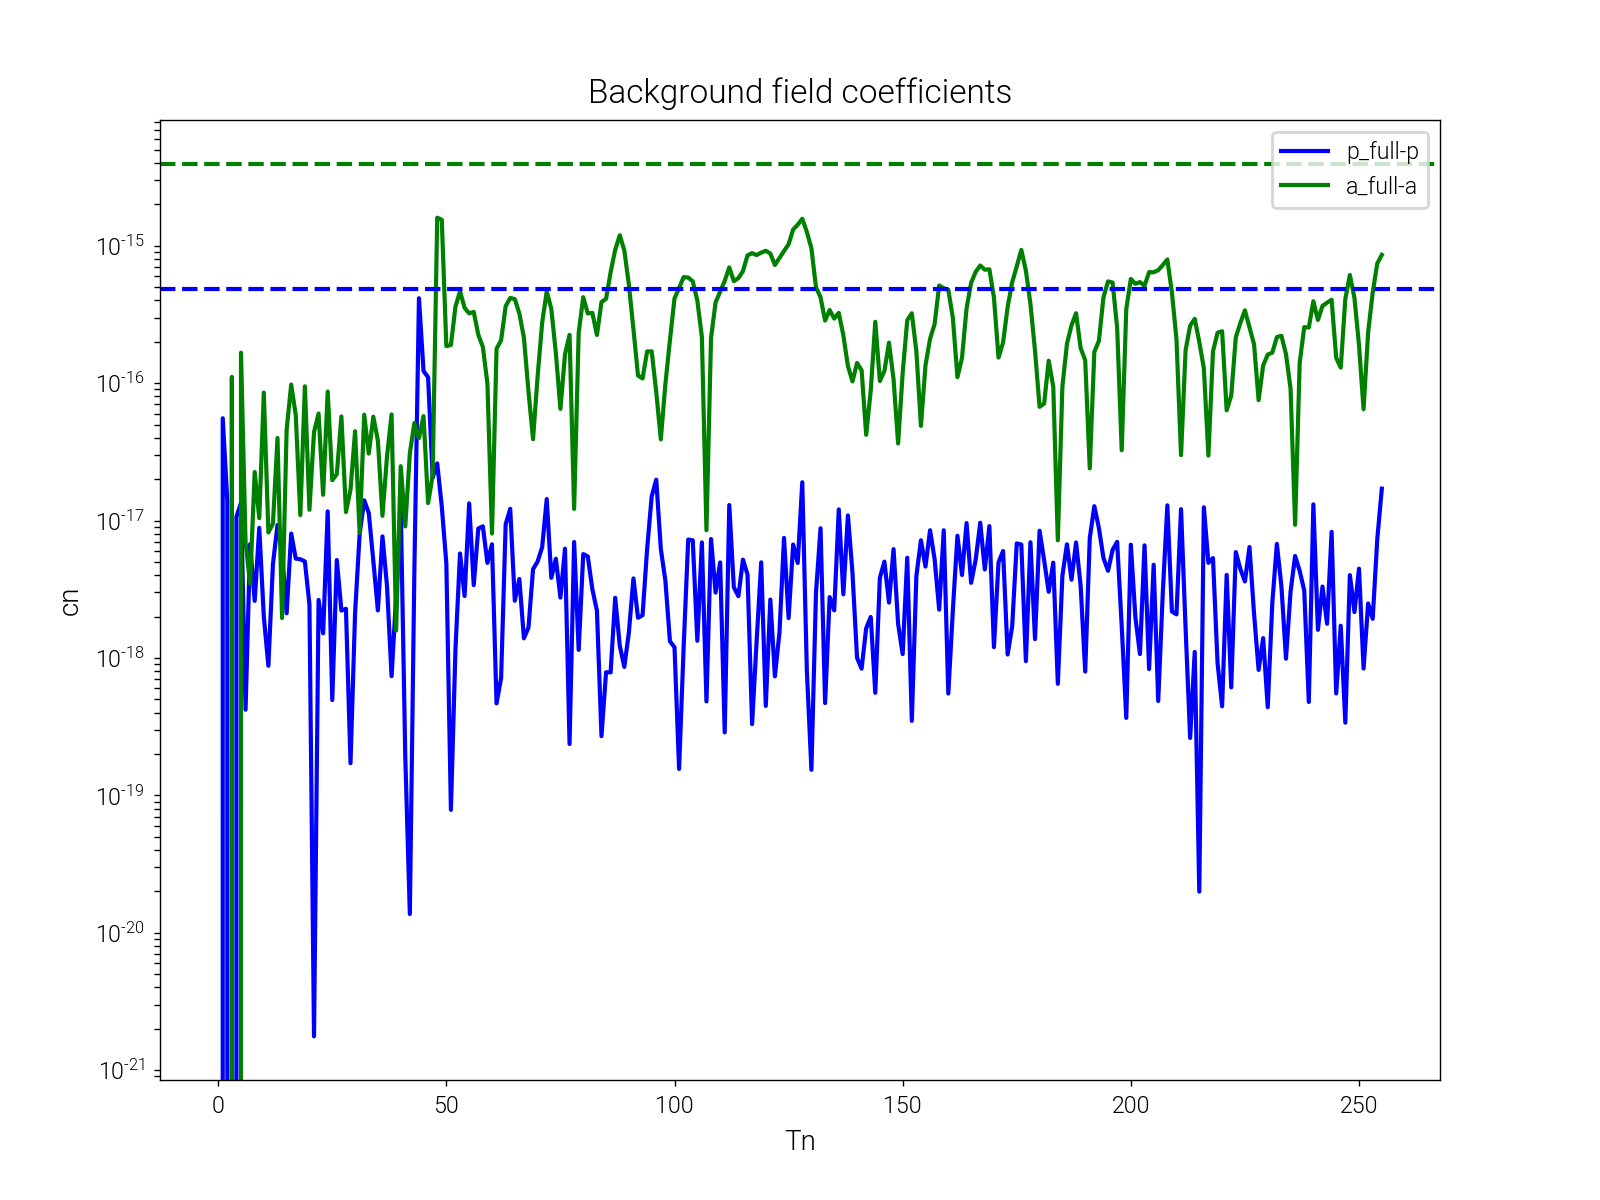

In [167]:
# Plot coefficient errors
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p_full['c']-p['c']), '-', label='p_full-p')
axes.semilogy(np.abs(a_full['c']-a['c']), '-', label='a_full-a')
axes.axhline(param.pressure_floor*np.max(np.abs(p_full['c'])), ls='dashed', c='b')
axes.axhline(param.background_floor*np.max(np.abs(a_full['c'])), ls='dashed', c='g')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>


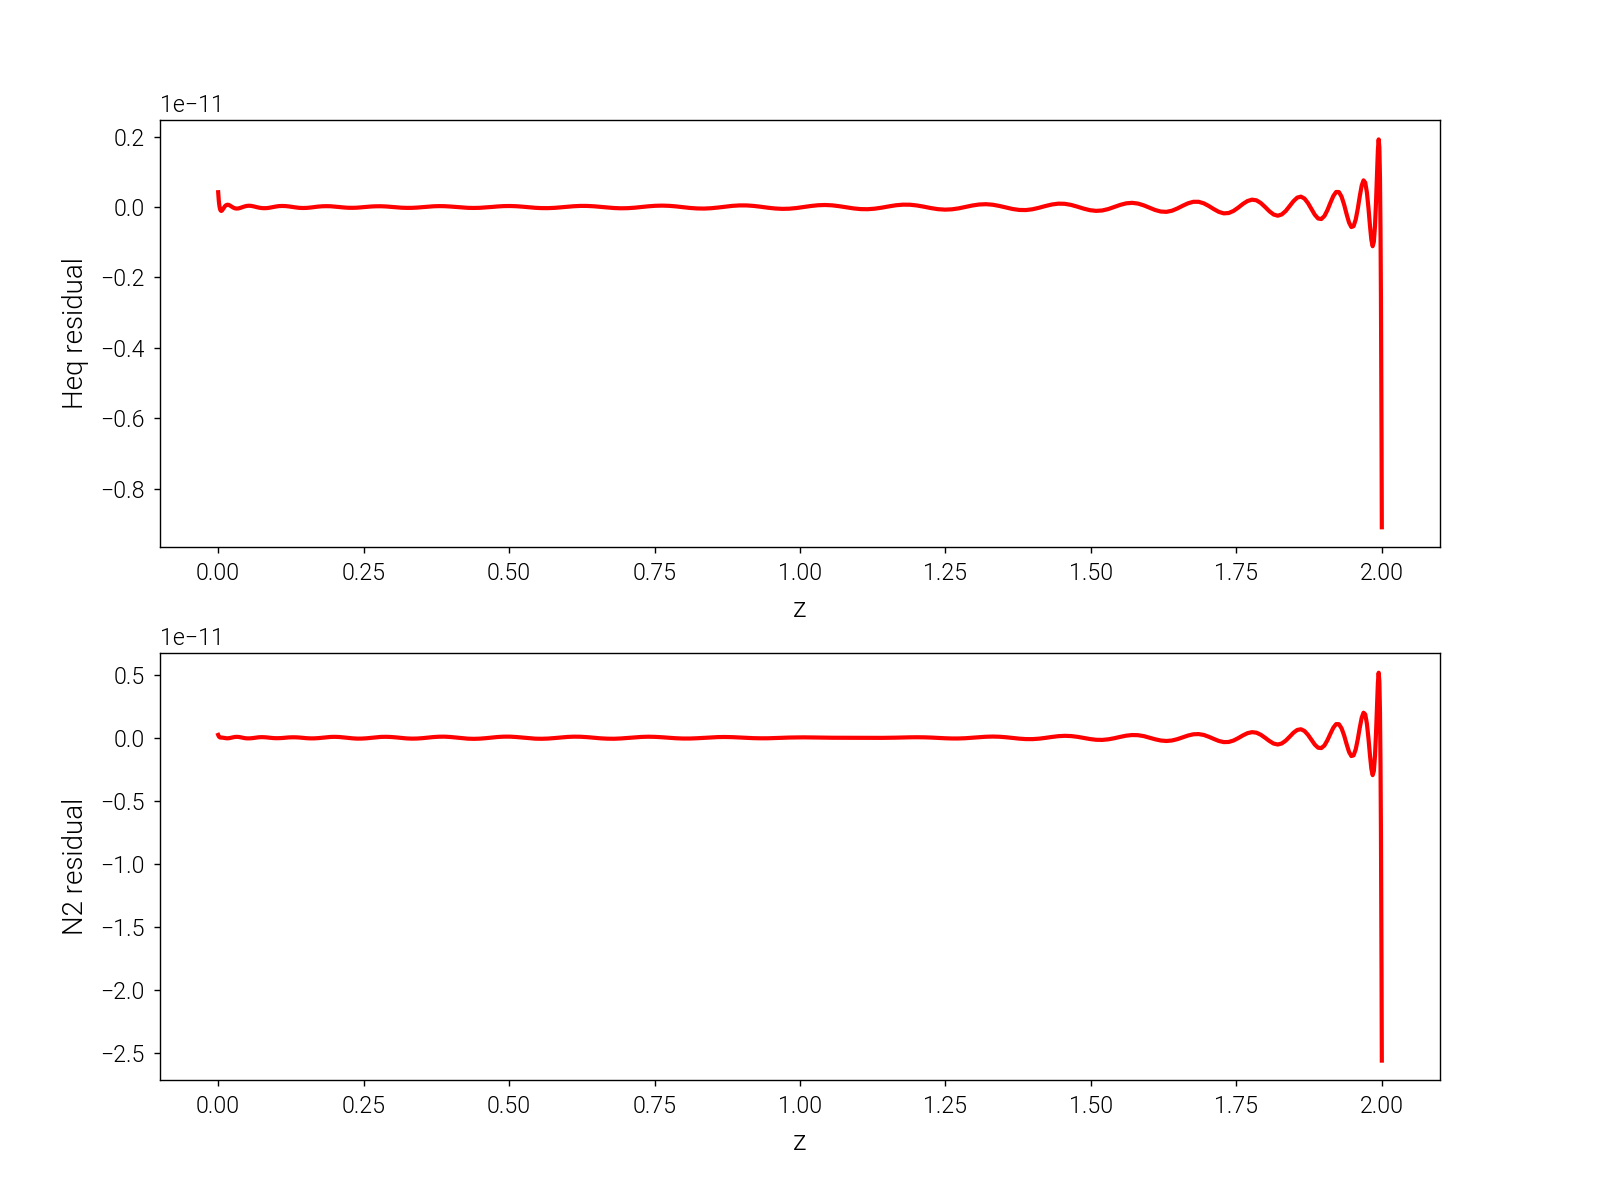

Heq Linf error: 9.090771997349675e-12
N2 Linf error: 2.5608873366417894e-11


In [168]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Examine hydrostatic equilibrium residual
z = domain.grid(0)
heq.set_scales(1)
ax1.plot(z, heq['g'], '-r')
ax1.set_xlabel('z')
ax1.set_ylabel('Heq residual')
print('Heq Linf error:', np.max(np.abs(heq['g'])))

# Examine buoyancy frequency residual
N2_ref = param.N2_func(z)
N2.set_scales(1)
ax2.plot(z, N2['g']-N2_ref, '-r')
ax2.set_xlabel('z')
ax2.set_ylabel('N2 residual')
print('N2 Linf error:', np.max(np.abs(N2['g']-N2_ref)))

## Plot atmospheric structure

In [169]:
z = domain.grid(0)
# Pressure scale height
Hp = (a * p / param.g).evaluate()
# Adiabatic sound speed squared
cs2 = (param.γ * p * a).evaluate()
# Acoustic cutoff frequency
ωc = (cs2**0.5 / 2 / Hp).evaluate()
# Adiabat
γ = param.γ
p_ad = (1 - (γ-1)*z/γ)**(γ/(γ-1))

<IPython.core.display.Javascript object>


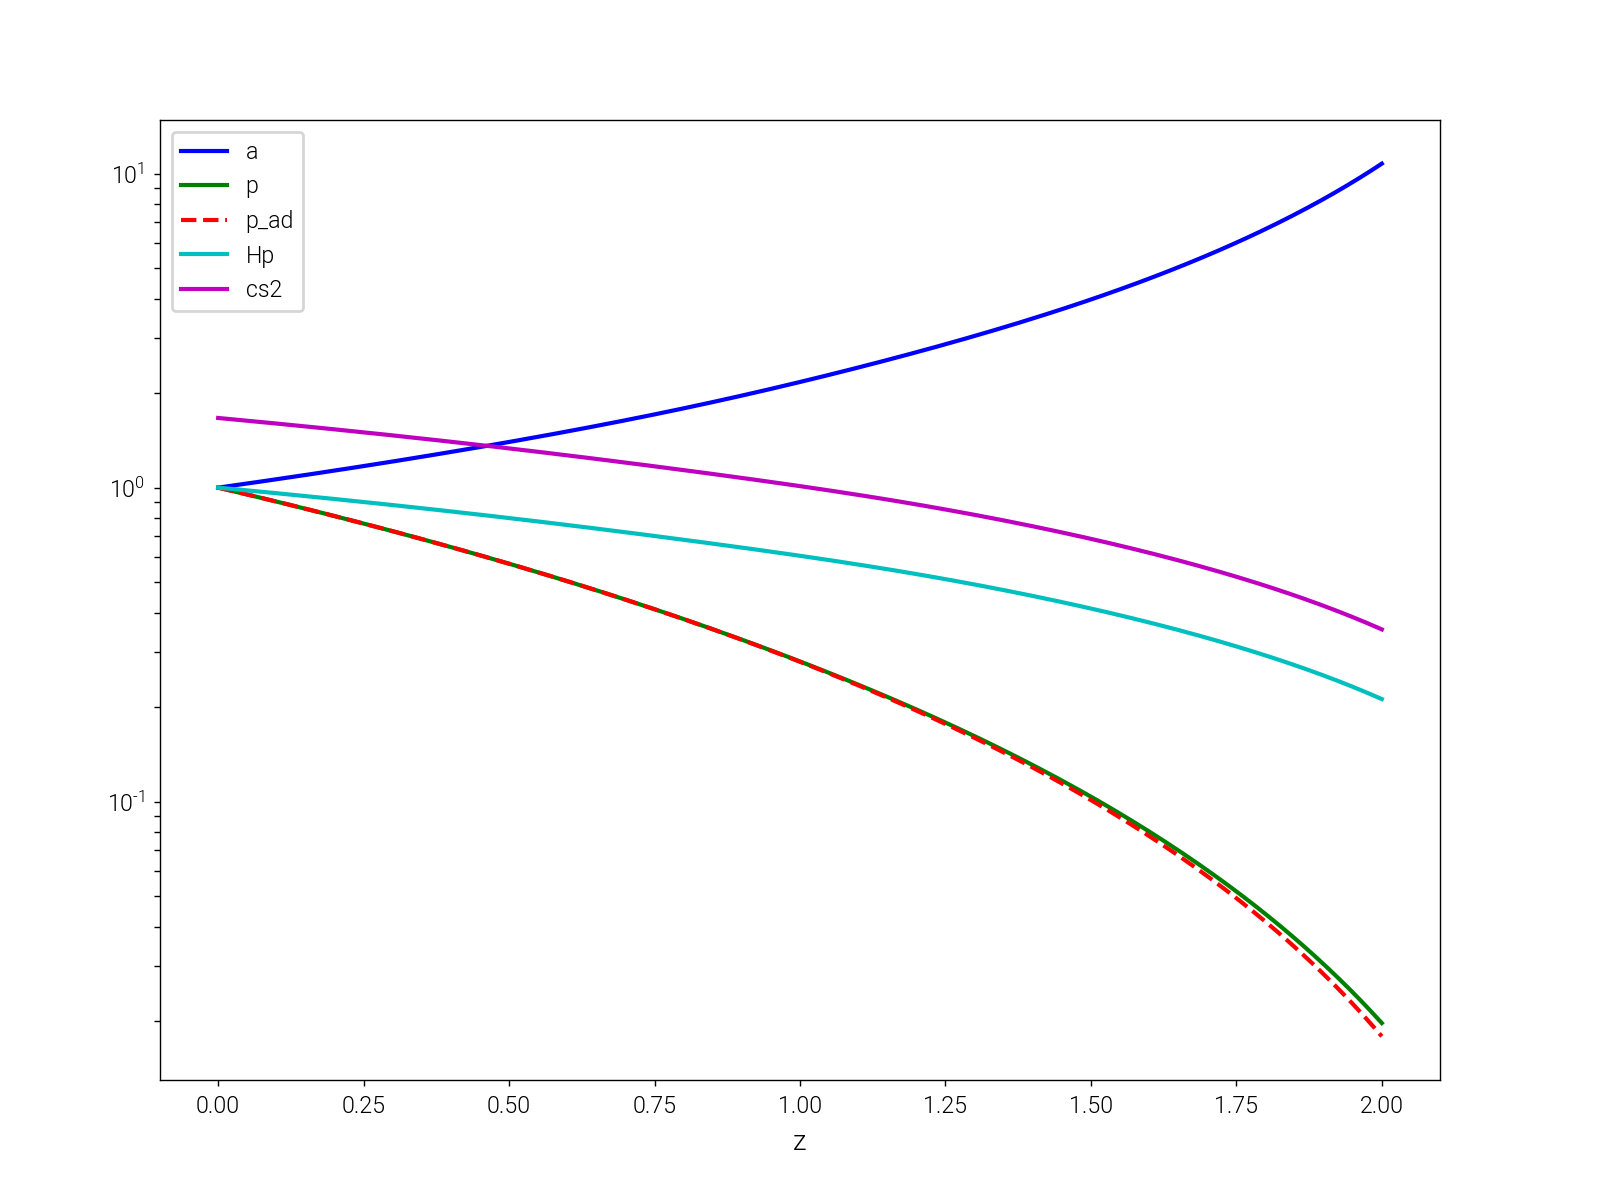

In [170]:
z = domain.grid(0)
fig, axes = plt.subplots(1, 1)
a.set_scales(1)
p.set_scales(1)
Hp.set_scales(1)
cs2.set_scales(1)
axes.plot(z, a['g'], label='a')
axes.plot(z, p['g'], label='p')
axes.plot(z, p_ad, '--', label='p_ad')
axes.plot(z, Hp['g'], label='Hp')
axes.plot(z, cs2['g'], label='cs2')
axes.axhline(0, c='k')
axes.set_xlabel('z')
axes.set_yscale('log')
axes.legend(loc='upper left')

In [171]:
# Number of pressure scale heights
np.log(p['g'][-1]/p['g'][0])

-3.926032867298299

<IPython.core.display.Javascript object>


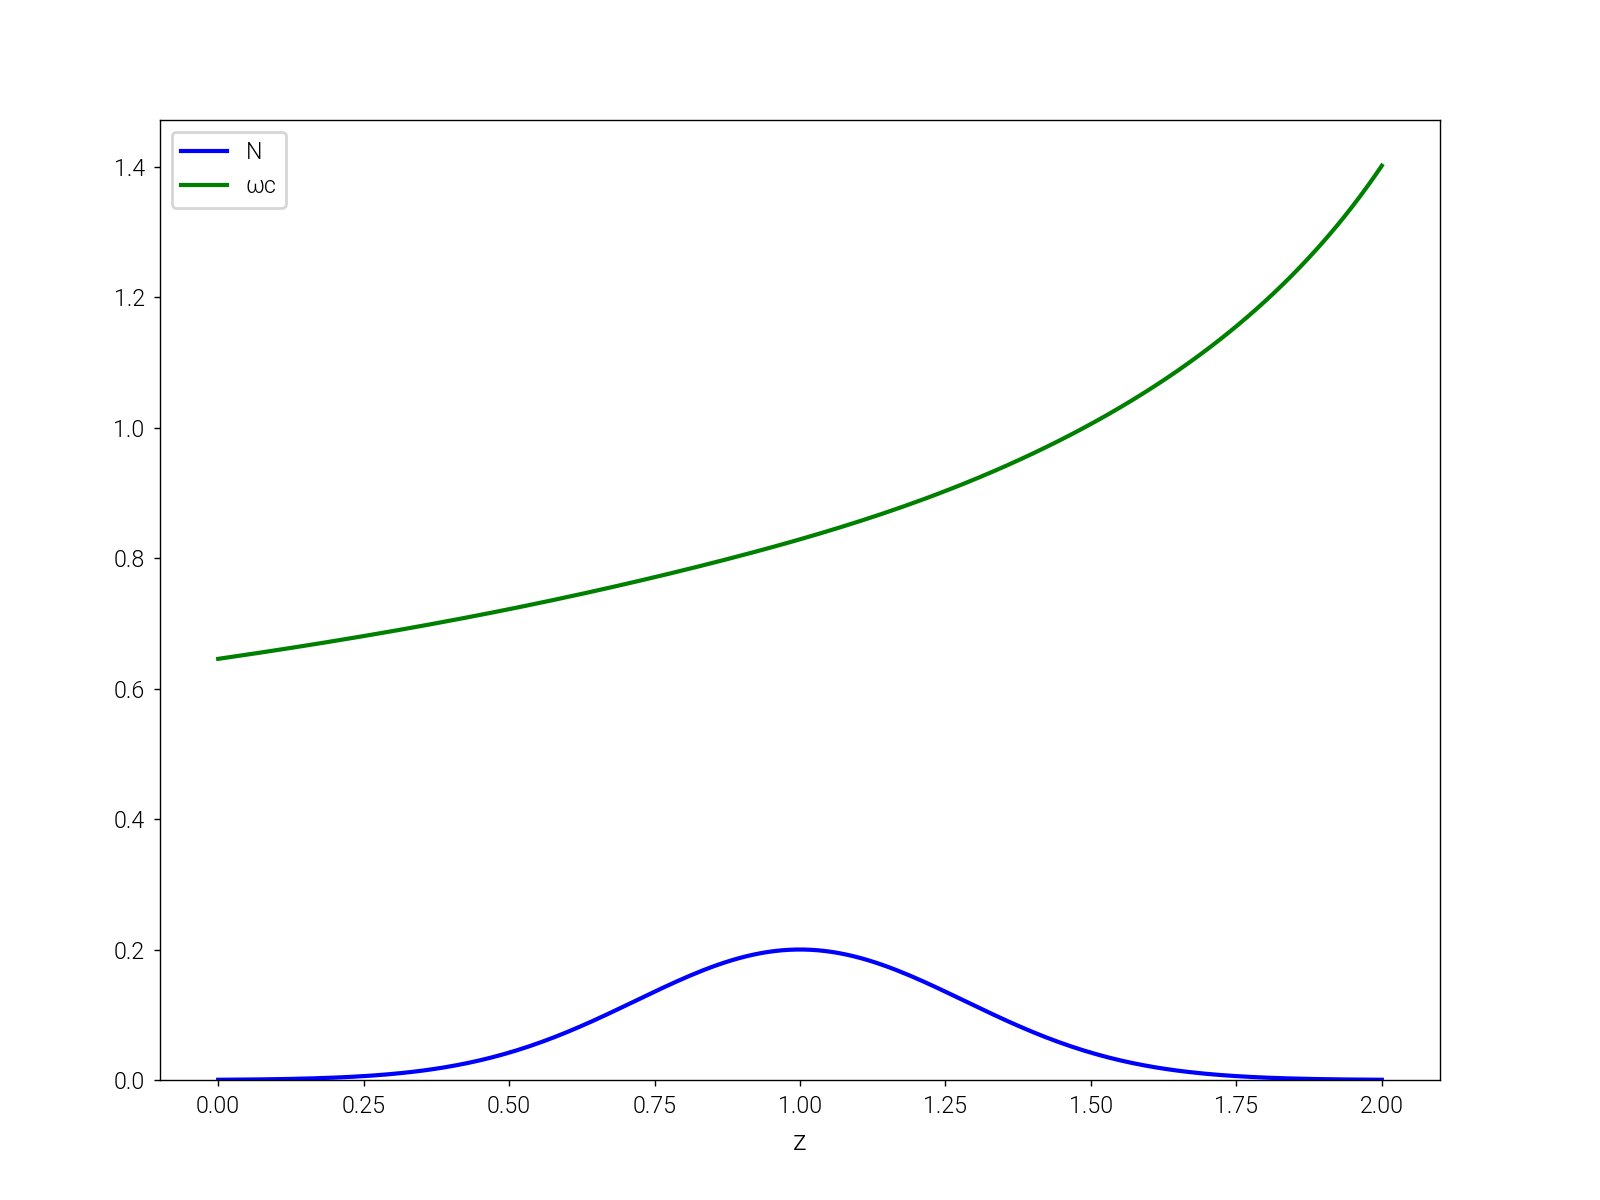

(0, 1.4714179165876045)

In [174]:
fig, axes = plt.subplots(1, 1)
N2.set_scales(1)
ωc.set_scales(1)
axes.plot(z, N2['g']**0.5, label='N')
#axes.plot(z, N2_ref**0.5, '--', label='Nr')
axes.plot(z, ωc['g'], label='ωc')
axes.set_xlabel('z')
axes.legend(loc='upper left')
axes.set_ylim(0, None)